<a href="https://colab.research.google.com/github/thisisZAQ/Decoding-Fiscal-Narratives-A-20-Year-NLP-Study-of-India-s-Union-Budgets/blob/main/Budget_Speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **start here**

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Load the CSV file
file_path = '/content/Speech_20years.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Clean the column names by stripping extra spaces
df.columns = df.columns.str.strip()

# Drop rows with missing speech data and group by Year and Finance Minister
df_cleaned = df[['Year', 'Minister', 'Speech']].dropna()
df_grouped = df_cleaned.groupby(['Year', 'Minister'])['Speech'].apply(lambda x: ' '.join(x)).reset_index()




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [33]:
# Calculate the length of each speech in words
df_grouped['Speech Length'] = df_grouped['Speech'].apply(lambda x: len(x.split()))

# Group by Finance Minister and calculate the total speech length for each minister
speech_length_by_minister = df_grouped.groupby('Minister')['Speech Length'].sum().reset_index()

# Sort by speech length for better visualization
speech_length_by_minister = speech_length_by_minister.sort_values(by='Speech Length', ascending=False)

# Display the results
speech_length_by_minister.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Minister,Speech Length
2,P. Chidambaram,77121
0,Arun Jaitley,71043
1,Nirmala Sitharaman,59046
3,Pranab Mukherjee,51514


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [34]:
# Calculate the length of each speech in words
df_grouped['Speech Length'] = df_grouped['Speech'].apply(lambda x: len(x.split()))

# Group by Finance Minister and calculate the total speech length for each minister
speech_length_by_minister = df_grouped.groupby('Minister')['Speech Length'].sum().reset_index()

# Sort by speech length for better visualization
speech_length_by_minister = speech_length_by_minister.sort_values(by='Speech Length', ascending=False)

# Display the results
speech_length_by_minister.head()

df_grouped.tail()
speech_length_by_minister.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Minister,Speech Length
2,P. Chidambaram,77121
0,Arun Jaitley,71043
1,Nirmala Sitharaman,59046
3,Pranab Mukherjee,51514


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



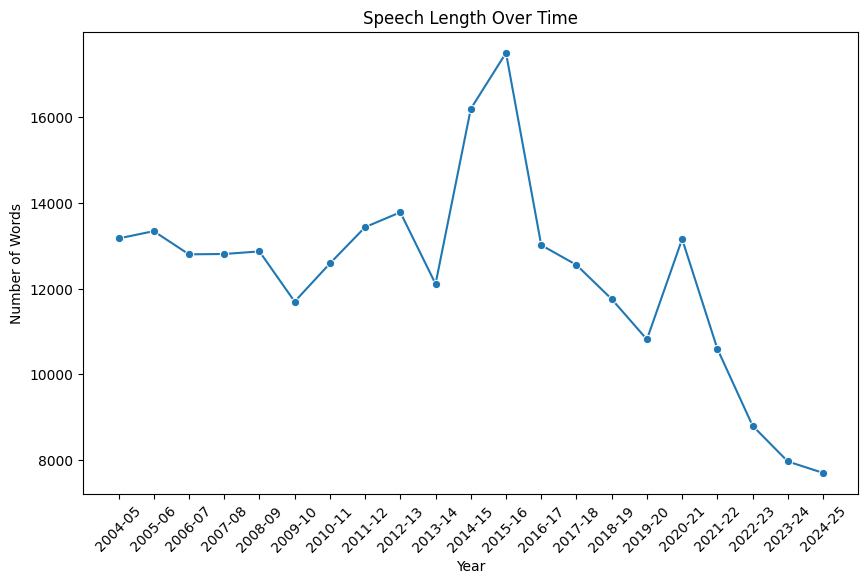

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Speech Length', data=df_grouped, marker='o')
plt.title('Speech Length Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)
plt.show()

In [36]:
import plotly.express as px

# Create the bar plot using Plotly Express
fig = px.bar(speech_length_by_minister,
             x='Speech Length',
             y='Minister',
             orientation='h',  # Horizontal bar plot
             title='Total Speech Length by Finance Minister',
             labels={'Speech Length': 'Speech Length (Word Count)', 'Minister': 'Minister'},
             color='Speech Length',  # Color based on speech length
             color_continuous_scale='Viridis')

# Customize layout (optional)
fig.update_layout(
    xaxis_title="Total Speech Length (Word Count)",
    yaxis_title="Finance Minister",
    height=600,
    width=900,
)

# Show the plot
fig.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [37]:
%pip install wordcloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



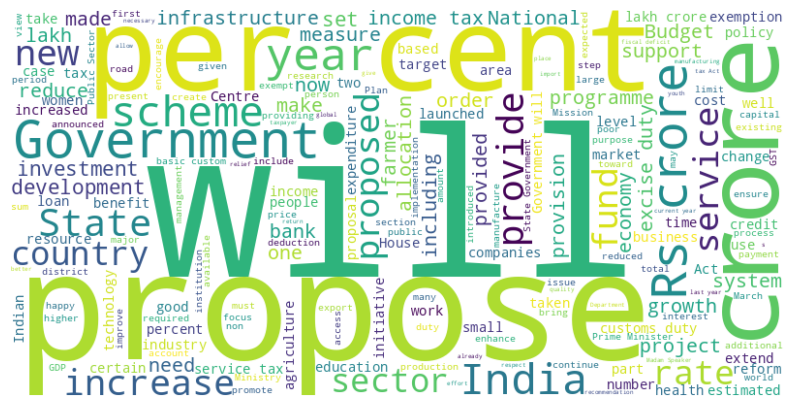

In [38]:
from wordcloud import WordCloud

# Combine all speeches into one large text
all_text = ' '.join(df_grouped['Speech'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
import spacy
from spacy import displacy

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

# Visualize named entities for the first speech
doc = nlp(df_grouped['Speech'][0])
displacy.render(doc, style='ent', jupyter=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [40]:
# Define themes and associated keywords
themes = {
    'inflation': ['inflation', 'prices', 'cost of living'],
    'tax': ['tax', 'taxation', 'income tax', 'corporate tax'],
    'growth': ['growth', 'development', 'GDP', 'economy'],
    'employment': ['employment', 'jobs', 'unemployment','MSME'],
    'budget': ['deficit', 'surplus', 'expenditure'],
    'education': ['education', 'schools', 'youth','children'],
    'defence': ['defence', 'national', 'security','threat'],
}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [41]:
import re

# Function to count keyword occurrences for a specific theme
def count_keywords(speech, keywords):
    count = 0
    for keyword in keywords:
        count += len(re.findall(r'\b' + re.escape(keyword) + r'\b', speech.lower()))
    return count

# Add columns for each theme, counting the occurrences of theme-related words
for theme, keywords in themes.items():
    df_grouped[theme] = df_grouped['Speech'].apply(lambda x: count_keywords(x, keywords))

# Display the dataframe with theme counts
df_grouped.head()
df_grouped.info()
df_grouped.to_csv('speech_with_theme_counts.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           21 non-null     object
 1   Minister       21 non-null     object
 2   Speech         21 non-null     object
 3   Speech Length  21 non-null     int64 
 4   inflation      21 non-null     int64 
 5   tax            21 non-null     int64 
 6   growth         21 non-null     int64 
 7   employment     21 non-null     int64 
 8   budget         21 non-null     int64 
 9   education      21 non-null     int64 
 10  defence        21 non-null     int64 
dtypes: int64(8), object(3)
memory usage: 1.9+ KB


In [42]:
import plotly.express as px

# Group by Finance Minister and sum the keyword counts for each theme
theme_counts_by_minister = df_grouped.groupby('Minister')[list(themes.keys())].sum().reset_index()

# Melt the DataFrame to make it long-form for easier plotting
theme_counts_melted = theme_counts_by_minister.melt(id_vars='Minister', var_name='Theme', value_name='Count')

# Plot the theme mentions using Plotly Express
fig = px.bar(theme_counts_melted,
             x='Minister',
             y='Count',
             color='Theme',
              color_discrete_sequence=px.colors.qualitative.T10,
             title='Theme Mentions by Finance Minister',
             labels={'Count': 'Number of Mentions', 'Minister': 'Finance Minister'},
             barmode='group',
             template='plotly_dark')

# Customize layout
fig.update_layout(xaxis_title='Finance Minister', yaxis_title='Number of Mentions', height=600, width=1000)
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [43]:
import plotly.express as px

# Plot the theme mentions using a stacked bar chart
fig = px.bar(theme_counts_melted,
             x='Minister',
             y='Count',
             color='Theme',
             title='Comparison of Themes by Finance Minister',
             labels={'Count': 'Number of Mentions', 'Name of Finance Minister': 'Finance Minister'},
             barmode='stack',
             template='plotly_dark') # Use 'stack' to create a stacked bar chart

fig.update_layout(xaxis_title='Finance Minister', yaxis_title='Number of Mentions', height=600, width=1000)
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [44]:
import plotly.graph_objects as go
import numpy as np

# Pivot the data to get ministers as rows and themes as columns
heatmap_data = theme_counts_by_minister.set_index('Minister')

# Create a heatmap
fig = go.Figure(data=go.Heatmap(
        z=heatmap_data.values,
        x=heatmap_data.columns,
        y=heatmap_data.index,
        colorscale='Viridis'))

# Update layout
fig.update_layout(title='Heatmap of Theme Mentions by Finance Minister',
                  xaxis_title='Themes',
                  yaxis_title='Finance Minister',
                  template='plotly_dark',
                  height=600,
                  width=1000)

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [53]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import spacy

# Load your dataset
df = pd.read_csv('/content/Speech_20years.csv')
df['Speech'] = df['Speech'].fillna('')
df['Year'] = df['Year'].astype(str).str.split('-').str[0]  # Ensure proper year format

# Load spaCy model and preprocess the speeches
nlp = spacy.load('en_core_web_sm')

# Preprocessing and topic modeling
def preprocess(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

df['tokens'] = df['Speech'].apply(preprocess)

# Create Gensim dictionary and corpus for LDA
dictionary = Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Train LDA model
lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Assign topics to each speech
def get_dominant_topic(bow):
    return max(lda_model[bow], key=lambda x: x[1])[0]  # Get the most dominant topic

df['dominant_topic'] = [get_dominant_topic(bow) for bow in corpus]

# Extract organizations using spaCy
def extract_orgs(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == 'ORG']  # Extract organizations

df['Organizations'] = df['Speech'].apply(extract_orgs)


# Create the source-target data for the Sankey diagram
sankey_data = []
for index, row in df.iterrows():
    for org in row['Organizations']:
        sankey_data.append({
            'source': row['Minister'],  # Finance Minister
            'target': f'Topic {row["dominant_topic"]}',  # Dominant Topic
            'final_target': org,  # Organization
        })


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [54]:
# Filter only top 10 organizations based on frequency of mentions
top_orgs = sankey_df['final_target'].value_counts().nlargest(10).index
filtered_sankey_df = sankey_df[sankey_df['final_target'].isin(top_orgs)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [52]:
import plotly.graph_objects as go

# Prepare data for filtered Sankey diagram
filtered_all_nodes = list(pd.concat([filtered_sankey_df['source'], filtered_sankey_df['target'], filtered_sankey_df['final_target']]).unique())
filtered_node_map = {name: i for i, name in enumerate(filtered_all_nodes)}

filtered_sources = [filtered_node_map[src] for src in filtered_sankey_df['source']]
filtered_targets = [filtered_node_map[tgt] for tgt in filtered_sankey_df['target']]
filtered_final_targets = [filtered_node_map[org] for org in filtered_sankey_df['final_target']]

filtered_sources += [filtered_node_map[tgt] for tgt in filtered_sankey_df['target']]
filtered_targets += [filtered_node_map[org] for org in filtered_sankey_df['final_target']]

filtered_values = [1] * len(filtered_sources)

colors = {
    'ministers': 'rgba(31, 119, 180, 0.8)',  # blue
    'topics': 'rgba(255, 127, 14, 0.8)',     # orange
    'organizations': 'rgba(44, 160, 44, 0.8)' # green
}

node_colors = []
for node in filtered_all_nodes:
    if node in filtered_sankey_df['source'].values:
        node_colors.append(colors['ministers'])  # Finance Ministers
    elif node in filtered_sankey_df['target'].values:
        node_colors.append(colors['topics'])     # Topics
    else:
        node_colors.append(colors['organizations'])  # Organizations

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=filtered_all_nodes,
        color=node_colors  # Apply the colors
    ),
    link=dict(
        source=filtered_sources,
        target=filtered_targets,
        value=filtered_values
    )
))

# Update layout with title and apply a vibrant theme
fig.update_layout(
    title_text="Colorful Sankey Diagram of Budget Speech Analysis",
    font_size=12,
    template="plotly",
    paper_bgcolor="white",  # Make the background white for more contrast
    plot_bgcolor="white"
)

# Show the diagram
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# LDA

In [ ]:
!pip install pandas spacy gensim pyLDAvis matplotlib


In [ ]:
import spacy
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.models import LdaModel

# Load spaCy model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Function to preprocess text (tokenization, lemmatization, stopwords removal)
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

# Define custom stopwords (domain-specific words)
custom_stopwords = ['cent', 'crore', 'propose', 'year', 'sector', 'government', 'duty', 'lakh','rate','shall','new','high','provide','rs']

# Load the spaCy model and extend its stopwords
nlp = spacy.load('en_core_web_sm')
for word in custom_stopwords:
    nlp.vocab[word].is_stop = True

# Apply preprocessing to each speech
df_grouped['tokens'] = df_grouped['Speech'].apply(preprocess)

# Create a Gensim dictionary and corpus
dictionary = Dictionary(df_grouped['tokens'])
corpus = [dictionary.doc2bow(text) for text in df_grouped['tokens']]

# Display the processed tokens and corpus
print(dictionary)
print(corpus[:1])  # Display the first document's bag of words


In [ ]:
# Set the number of topics (you can adjust this based on the results)
num_topics = 5

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Print the topics with words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the pyLDAvis visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization in
pyLDAvis.display(lda_display)


#Sentiment Analysis

In [ ]:
!pip install vaderSentiment


In [ ]:
# Load the dataset (replace 'path_to_your_budget_file.csv' with your actual file path)
df_senti = pd.read_csv('/content/Speech_20years.csv')

# Clean the column names if needed
df_senti.columns = df.columns.str.strip()
# Replace NaN values in the 'Speech' column with an empty string
df_senti['Speech'] = df['Speech'].fillna('')


# Display the first few rows of the dataframe
df_senti.head()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Replace NaN values in the 'Speech' column with an empty string
df['Speech'] = df['Speech'].fillna('')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment for each speech
def get_sentiment(text):
    return analyzer.polarity_scores(text)

# sentiment analysis to each speech
df_senti['Sentiment'] = df['Speech'].apply(lambda speech: get_sentiment(speech))

# Split the VADER sentiment into individual columns
df_sentiment = df_senti['Sentiment'].apply(pd.Series)

# Merge the sentiment scores back into the original dataframe
df = pd.concat([df_senti, df_sentiment], axis=1)

# Display the updated dataframe with sentiment scores
df.head()
df.tail()
df['Year']


In [ ]:
# Extract the starting year from the 'Year' column
df['Year'] = df['Year'].astype(str).str.split('-').str[0]

# Convert the 'Year' column to numeric
df['Year'] = df['Year'].astype(str).str.split('-').str[0]
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')



In [ ]:
# Calculate the average sentiment score for each year
sentiment_over_time = df.groupby('Year')['compound'].mean().reset_index()

# Ensure the 'Year' column is sorted numerically
sentiment_over_time = sentiment_over_time.sort_values('Year')

# Plot the line chart for sentiment over time
import plotly.express as px

fig = px.line(sentiment_over_time,
              x='Year',
              y='compound',
              title='Sentiment of Budget Speeches Over Time',
              labels={'compound': 'Sentiment Score', 'Year': 'Year'},
              template='plotly_dark')

fig.update_layout(xaxis_title='Year', yaxis_title='Average Sentiment Score')
fig.show()


In [ ]:
# Calculate the average sentiment score for each finance minister
sentiment_by_minister = df.groupby('Minister')['compound'].mean().reset_index()

fig = px.bar(sentiment_by_minister,
             x='Minister',
             y='compound',
             title='Average Sentiment by Finance Minister',
             labels={'compound': 'Sentiment Score', 'Minister': 'Finance Minister'},
            template='plotly_dark')

fig.update_layout(xaxis_title='Finance Minister', yaxis_title='Average Sentiment Score')
fig.show()


# NER VISULISATION

In [ ]:

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Load your budget speeches dataset
df = pd.read_csv('/content/Speech_20years.csv')
df['Year'] = df['Year'].astype(str).str.split('-').str[0]
df['Speech'] = df['Speech'].fillna('')
# Function to extract named entities
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entity text and label
    return entities

# Apply the function to extract entities
df['Entities'] = df['Speech'].apply(extract_entities)

# Create a dataframe of entity mentions per speech
entity_data = []
for index, row in df.iterrows():
    for entity, label in row['Entities']:
        entity_data.append({'Year': row['Year'], 'Entity': entity, 'Label': label})

entity_df = pd.DataFrame(entity_data)


In [ ]:
# Count the frequency of each entity label over time
entity_counts = entity_df.groupby(['Year', 'Label']).size().reset_index(name='Count')

# Optional: Filter for the top N most common entity types (e.g., ORG, GPE, DATE)
top_entity_labels = entity_counts.groupby('Label')['Count'].sum().nlargest(5).index
entity_counts = entity_counts[entity_counts['Label'].isin(top_entity_labels)]


In [ ]:
import plotly.express as px

# Create a line chart to show how entity mentions changed over time
fig = px.line(entity_counts,
              x='Year',
              y='Count',
              color='Label',
              title='Entity Mentions Over Time',
              labels={'Count': 'Number of Mentions', 'Year': 'Year', 'Label': 'Entity Type'})

# Customize the chart
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Mentions',
    template='plotly_dark',
    paper_bgcolor='#2B2B2B',
    plot_bgcolor='#2B2B2B',
    font_color='white'
)

fig.show()


In [ ]:
# Function to extract organizations (ORG) from speeches
def extract_orgs(text):
    doc = nlp(text)
    orgs = [ent.text for ent in doc.ents if ent.label_ == 'ORG']  # Extract only organizations (ORG)
    return orgs

# Apply the function to extract organizations from each speech
df['Organizations'] = df['Speech'].apply(extract_orgs)

# Create a dataframe of organization mentions per speech
org_data = []
for index, row in df.iterrows():
    for org in row['Organizations']:
        org_data.append({'Year': row['Year'], 'Organization': org})

org_df = pd.DataFrame(org_data)

# Count the number of times each organization is mentioned per year
org_counts = org_df.groupby(['Year', 'Organization']).size().reset_index(name='Count')

# Optional: Filter for the top N organizations mentioned most frequently
top_orgs = org_counts.groupby('Organization')['Count'].sum().nlargest(10).index
org_counts = org_counts[org_counts['Organization'].isin(top_orgs)]


In [ ]:
import plotly.express as px

# Create a bar chart showing how many times each organization is mentioned over time
fig = px.bar(org_counts,
             x='Year',
             y='Count',
             color='Organization',
             title='Organization Mentions Over Time',
             labels={'Count': 'Number of Mentions', 'Year': 'Year', 'Organization': 'Organization'},
             barmode='group')

# Customize the chart (dark theme)
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Mentions',
    template='plotly_dark',
    paper_bgcolor='#2B2B2B',
    plot_bgcolor='#2B2B2B',
    font_color='white'
)

fig.show()


In [ ]:
!pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout for the app
app.layout = html.Div(
    children=[
        html.H1("Organization Mentions in Budget Speeches", style={'textAlign': 'center'}),
        dcc.Dropdown(
            id='org-dropdown',
            options=[{'label': org, 'value': org} for org in org_df['Organization'].unique()],
            value=org_df['Organization'].unique()[0],
            style={'width': '50%', 'margin': 'auto'}
        ),
        dcc.Graph(id='org-graph'),
    ]
)

# Callback to update graph based on selected organization
@app.callback(
    Output('org-graph', 'figure'),
    [Input('org-dropdown', 'value')]
)
def update_graph(selected_org):
    filtered_df = org_counts[org_counts['Organization'] == selected_org]

    fig = px.bar(filtered_df,
                 x='Year',
                 y='Count',
                 color='Organization',
                 title=f'{selected_org} Mentions Over Time',
                 labels={'Count': 'Number of Mentions', 'Year': 'Year'},
                 barmode='group')

    fig.update_layout(template='plotly_dark')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
